In [1]:
import torch
import os
import pickle
from tqdm import tqdm
from pylab import rcParams
from torch import nn, optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [2]:
# 폰트 설정 (Windows: Malgun Gothic, Mac: AppleGothic, Linux: 나눔고딕 등)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv('pre_df_교차로1558.csv')

In [4]:
df = df.drop(columns=['weekday'])
train_df = df[df['month'].isin([3,5,9])]
test_df = df[df['month'] == 11]

df_train = train_df.copy()
df_test = test_df.copy()

In [5]:
# 입력값만 스케일링
input_features = ['month', 'day', 'hour_decimal', 'latitude', 'longitude']

scaler_X = StandardScaler()

# 훈련 데이터와 테스트 데이터 입력값 스케일링
df_train[input_features] = scaler_X.fit_transform(df_train[input_features])
df_test[input_features] = scaler_X.transform(df_test[input_features])

# 타겟값 스케일링
scaler_y = StandardScaler()

# 타겟값 스케일링
df_train['traffic_volume'] = scaler_y.fit_transform(df_train[['traffic_volume']])
df_test['traffic_volume'] = scaler_y.transform(df_test[['traffic_volume']])

train_features = ['month','day', 'hour_decimal', 'latitude', 'longitude',
            'vehicle_대형', 'vehicle_소형', 'dir_1', 'dir_2', 'dir_3', 'dir_4', 'dir_5',
       'dir_6', 'dir_7', 'dir_8', 'dir_9', 'dir_10', 'dir_11', 'dir_12']
train_target = ['traffic_volume']

test_features = ['month','day', 'hour_decimal', 'latitude', 'longitude',
            'vehicle_대형', 'vehicle_소형', 'dir_1', 'dir_2', 'dir_3', 'dir_4', 'dir_5',
       'dir_6', 'dir_7', 'dir_8', 'dir_9', 'dir_10', 'dir_11', 'dir_12']
test_target = ['traffic_volume']

In [6]:
def create_sequences_by_intersection(df, seq_length, features, target):
    sequences = []
    targets = []
    
    # 교차로별로 그룹화
    grouped_intersections = df.groupby('교차로명')
    
    for intersection, group in grouped_intersections:
        # 시간대별로 그룹화
        grouped = group.groupby('datetime')
        time_groups = sorted(grouped.groups.keys())
        
        for i in range(len(time_groups) - seq_length + 1):
            sequence = []
            for j in range(seq_length):
                current_time = time_groups[i + j]
                current_data = grouped.get_group(current_time)[features].values
                mean_data = np.mean(current_data, axis=0)
                sequence.append(mean_data)
            
            target_time = time_groups[i + seq_length - 1]
            target_data = grouped.get_group(target_time)[target].values
            target_mean = np.mean(target_data)
            
            sequences.append(sequence)
            targets.append(target_mean)
    
    return np.array(sequences), np.array(targets)


In [9]:
# 훈련 데이터를 훈련셋과 검증셋으로 분할
train_size = int(len(df_train) * 0.8)  # 80%를 훈련셋으로 사용

# 데이터 분할
train_data = df_train[:train_size]
val_data = df_train[train_size:]  # 나머지 20%를 검증셋으로 사용
test_data = df_test  # 테스트셋은 별도의 데이터 사용

seq_length = 2

# 시퀀스 생성
X_train, y_train = create_sequences_by_intersection(train_data, seq_length, train_features, train_target)
X_val, y_val = create_sequences_by_intersection(val_data, seq_length, train_features, train_target)
X_test, y_test = create_sequences_by_intersection(test_data, seq_length, test_features, test_target)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(570, 2, 19)
(140, 2, 19)
(230, 2, 19)


In [10]:
def make_Tensor(array):
    return torch.from_numpy(array).float()

In [11]:
X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

# LSTM

In [18]:
class TrafficPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(TrafficPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self, batch_size=1):
        device = next(self.parameters()).device
        self.hidden = (
        torch.zeros(self.n_layers, batch_size, self.n_hidden,device=device),
        torch.zeros(self.n_layers, batch_size, self.n_hidden,device=device)
        )

    def forward(self, sequences):
        batch_size = sequences.size(0)
        self.reset_hidden_state(batch_size)

        # LSTM에 입력 전달
        lstm_out, self.hidden = self.lstm(sequences, self.hidden)

        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred.squeeze(-1)

In [19]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    train_hist = []
    val_hist = []

    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data):
            seq = torch.unsqueeze(seq, 0)
            batch_size = seq.size(0)  # 입력 시퀀스의 배치 크기
            model.reset_hidden_state(batch_size) # seq 별 hidden state reset

            # train loss
            y_pred = model(seq)
            y_pred = y_pred.squeeze(-1)  # 불필요한 차원 제거
            target = train_labels[idx].squeeze(-1)  # 타겟도 동일한 차원으로 조정
            loss = loss_fn(y_pred, target) 

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item() # 손실 누적

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])
                    val_loss += val_step_loss

            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                ## loss가 커졌다면 early stop
                if len(val_hist) > patience and val_hist[-patience] < val_hist[-1]:
                    print('\n Early Stopping')
                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')


    return model, train_hist, val_hist

In [30]:
# 모델 초기화
n_features = 19  # 입력 특성 수 
n_hidden = 16    # LSTM 히든 레이어의 크기
seq_len = 2      # 시퀀스 길이 (2.5시간 = 5개 시점)
n_layers = 1    # LSTM 레이어 수

model = TrafficPredictor(
    n_features=n_features,
    n_hidden=n_hidden,
    seq_len=seq_len,
    n_layers=n_layers
)


In [31]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=200,
    verbose=10,
    patience=200
)

Epoch 0 train loss: 0.03178923752871968 val loss: 0.03159050643444061
Epoch 10 train loss: 0.013641499124473468 val loss: 0.01384523045271635
Epoch 20 train loss: 0.009811762042886734 val loss: 0.01073977816849947
Epoch 30 train loss: 0.008095715125680152 val loss: 0.01046766061335802
Epoch 40 train loss: 0.007179134479154202 val loss: 0.013056399300694466
Epoch 50 train loss: 0.00682162030491088 val loss: 0.016869956627488136
Epoch 60 train loss: 0.006501935633247955 val loss: 0.0202441718429327
Epoch 70 train loss: 0.006292236383872432 val loss: 0.02366218902170658
Epoch 80 train loss: 0.006092652625598081 val loss: 0.026283523067831993
Epoch 90 train loss: 0.005800061301791478 val loss: 0.029000788927078247
Epoch 100 train loss: 0.005663078440433438 val loss: 0.03125061094760895
Epoch 110 train loss: 0.00548580747311469 val loss: 0.033678680658340454
Epoch 120 train loss: 0.005492183702467387 val loss: 0.03316201642155647
Epoch 130 train loss: 0.0054534391768796 val loss: 0.03559270

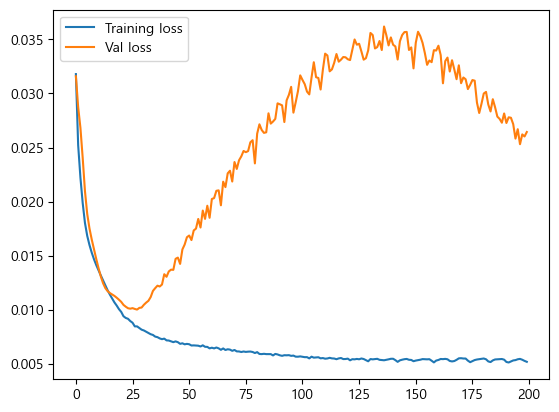

In [32]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [ ]:
# 입력값 스케일러 저장
with open("scaler_X.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

# 타겟값 스케일러 저장
with open("scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

In [ ]:
PATH = "12311408LSTMmodel.pth"  # 현재 디렉토리에 저장

In [ ]:
torch.save(model.state_dict(), PATH)

In [33]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state(batch_size=1)
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

In [34]:
# preds를 numpy array로 변환 (1D -> 2D)
preds = np.array(preds).reshape(-1, 1)

# 예측값 역스케일링
y_pred_original = scaler_y.inverse_transform(preds)

# 실제값 역스케일링
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))


In [35]:
# 매핑을 위해 학습에 사용된 데이터프레임과 동일한 데이터 필요
df_test['datetime'] = pd.to_datetime(df_test['datetime'])  # datetime 형식 변환
df_test = df_test.sort_values(by=['교차로명', 'datetime'])  # 교차로명과 시간으로 정렬

# 예측에 사용된 교차로별 데이터의 인덱스 추출
mapping_info = df_test[['datetime', '교차로명']].iloc[seq_length:].reset_index(drop=True)

mapping_info = mapping_info.drop_duplicates(subset=['datetime', '교차로명']).reset_index(drop=True)

unique_intersections = mapping_info['교차로명'].unique()

# 교차로의 개수
num_intersections = len(unique_intersections)

# 각 교차로에 할당할 데이터 개수
rows_per_intersection = len(y_test_original) // int(num_intersections)

In [36]:
# 결과를 저장할 리스트
results = []

# 교차로별 데이터 처리
start_idx = 0
for i, intersection in enumerate(unique_intersections):
    # 마지막 교차로는 나머지를 포함하여 할당
    if i == num_intersections - 1:
        end_idx = len(y_test_original)
    else:
        end_idx = start_idx + rows_per_intersection
    
    # 교차로별 예측값과 실제값 슬라이싱
    y_pred_intersection = y_pred_original[start_idx:end_idx]
    y_test_intersection = y_test_original[start_idx:end_idx]
    
    # 데이터가 비어 있는지 확인
    if len(y_pred_intersection) == 0 or len(y_test_intersection) == 0:
        print(f"Error: No data for {intersection}")
        continue

    # 다음 교차로로 이동
    start_idx = end_idx
    
    # 결과 저장 (딕셔너리 형태로)
    results.append({
        'intersection': intersection,
        'predicted': y_pred_intersection.flatten().tolist(),
        'actual': y_test_intersection.flatten().tolist()
    })

# 저장된 결과 확인
for result in results:
    print(f"{result['intersection']}:")
    print("Predicted:", result['predicted'])
    print("Actual:", result['actual'])


공촌3교4거리:
Predicted: [27.483297150387315, 25.901341432439573, 24.331925468483437, 22.788447724699903, 21.288581621846376, 19.855248328929747, 18.517722432676756, 14.463081566487084, 20.02830373755549, 20.818091540590828, 21.44585506943761, 21.911855940941454, 22.228389395073748, 22.413055742711908, 22.484408730263393, 20.211000629069222, 16.926623657038274, 16.432373804502028, 15.937318051797682, 15.4429419014739, 14.950583508660554, 14.461441198794173, 13.976594517249193]
Actual: [22.694444394200822, 23.972222227734388, 22.916666666976905, 22.222222229001886, 15.888888864456996, 13.916666968834681, 11.722222612493146, 7.9444437873565725, 7.9444437873565725, 9.083332582940626, 10.499999830309976, 8.111111760554806, 9.888888439218393, 8.333332717728936, 9.777777960631326, 19.388888861922, 18.1666664556251, 22.61111115937425, 23.277777789759366, 18.027777981504997, 15.833333625163462, 14.027777447421746, 11.750000608026186]
봉수교3거리:
Predicted: [25.16210525858223, 24.213907703754085, 23.258

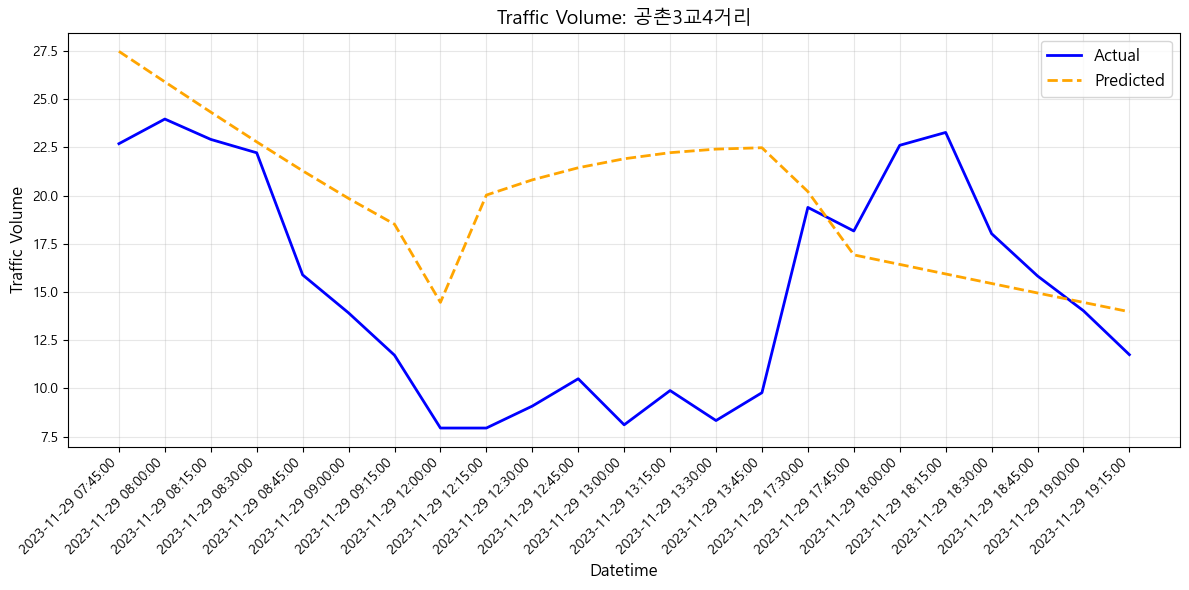

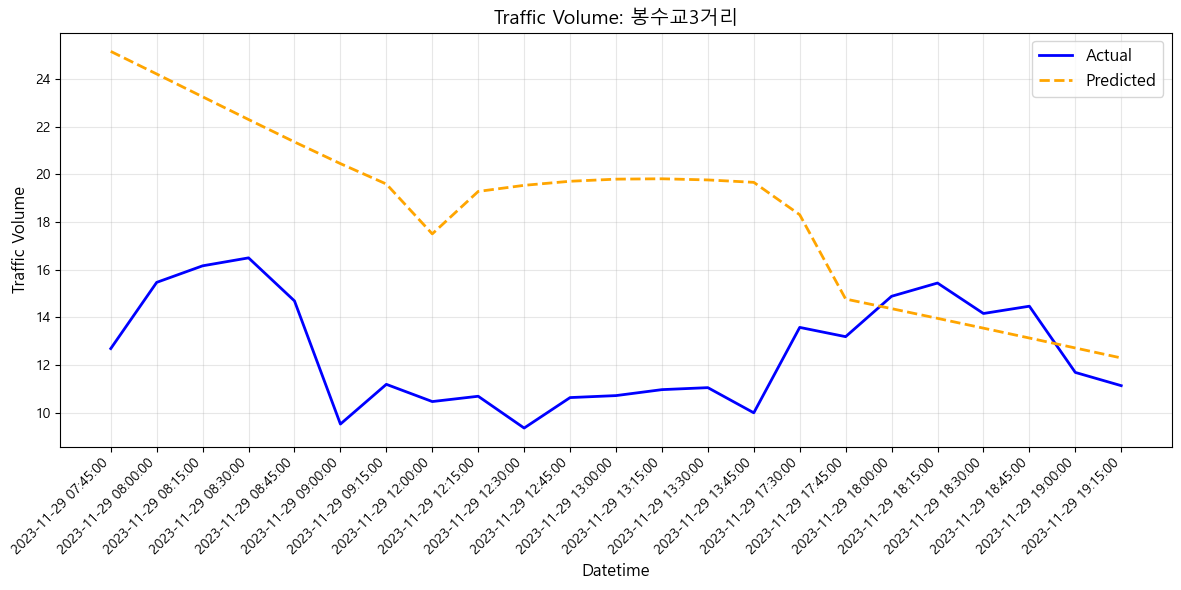

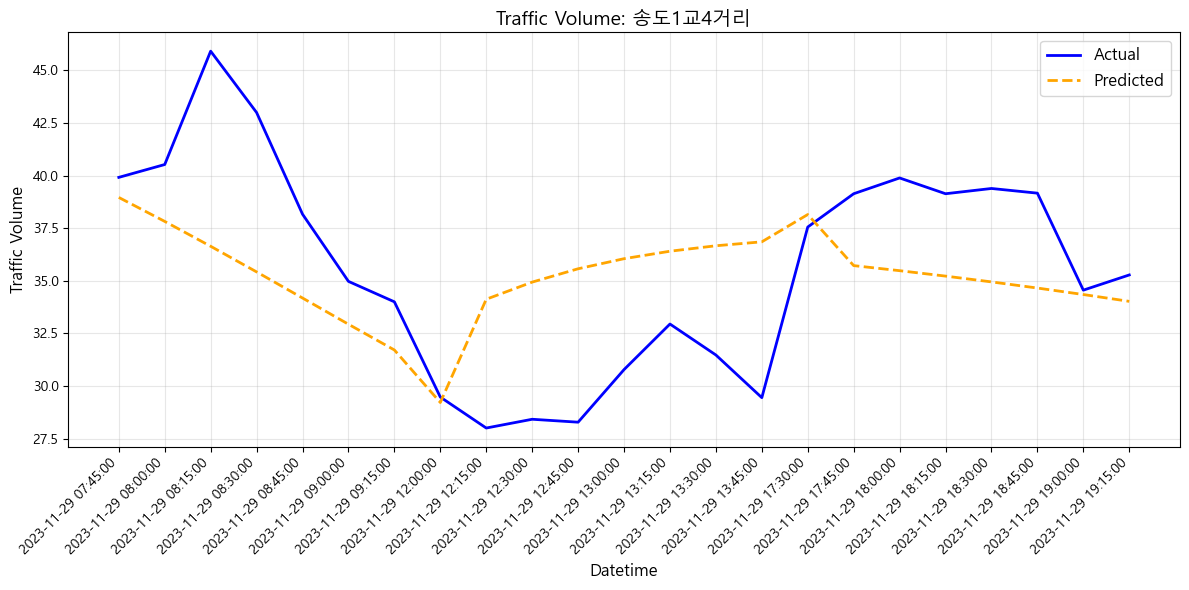

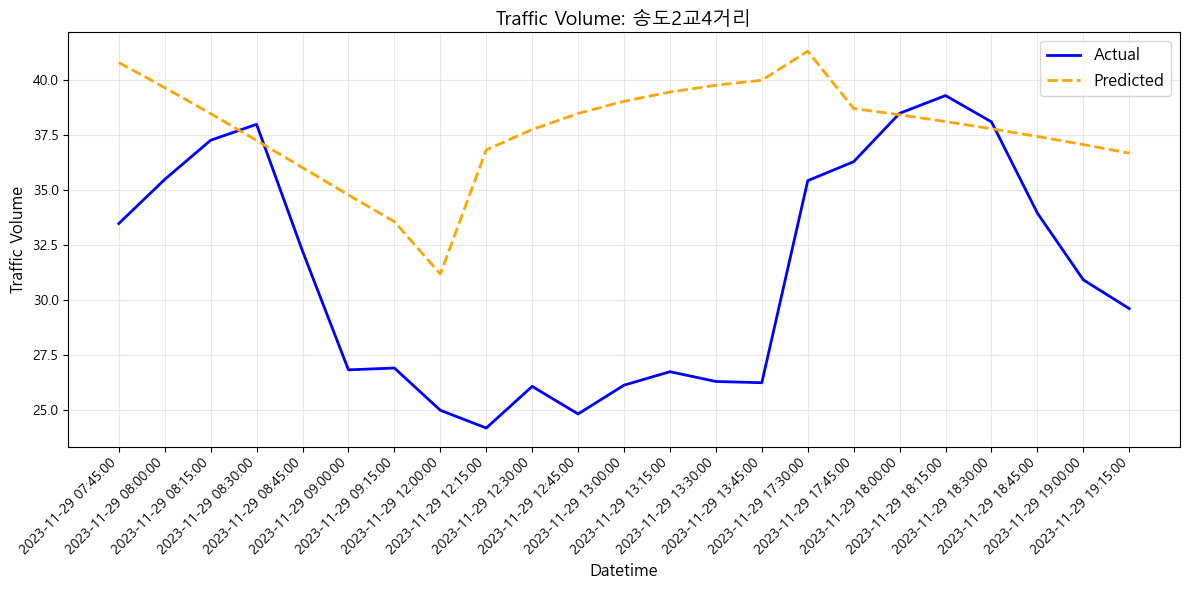

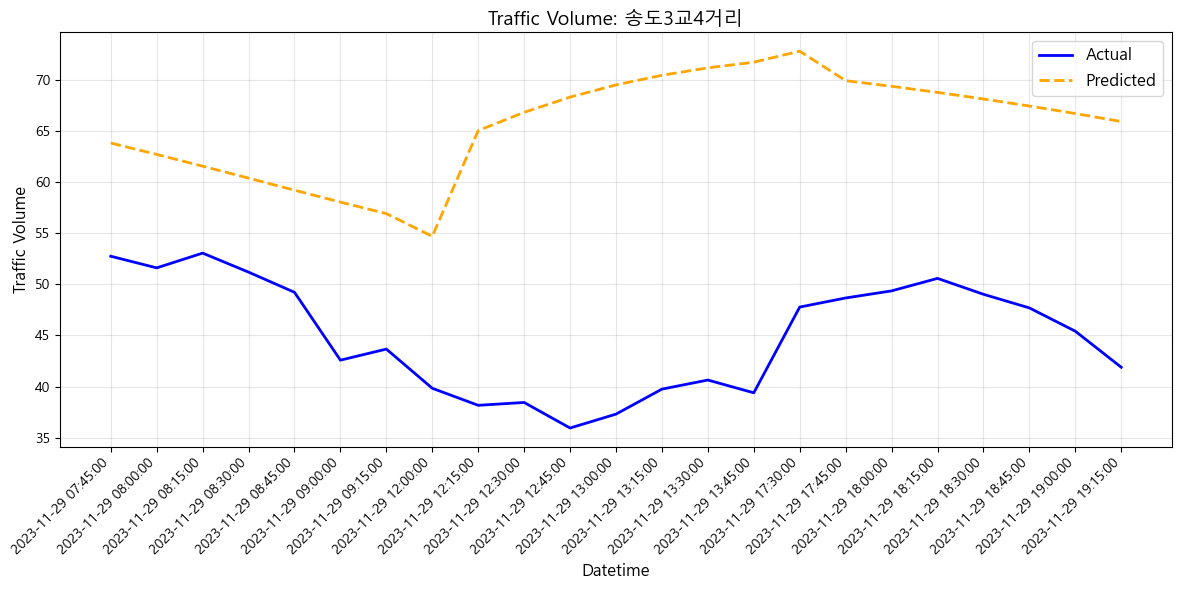

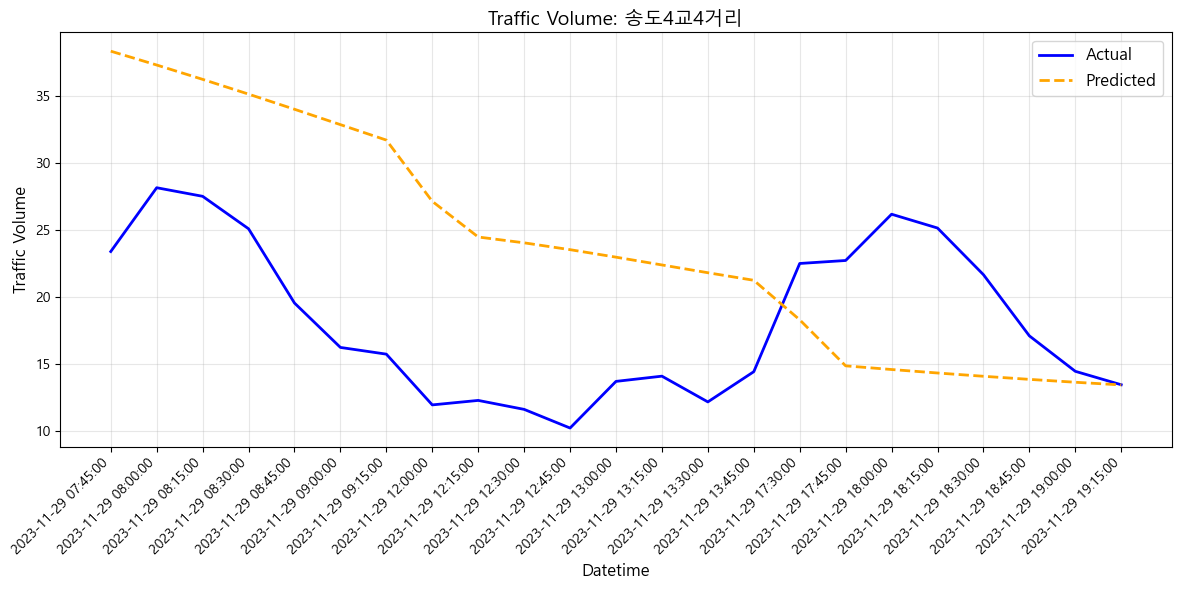

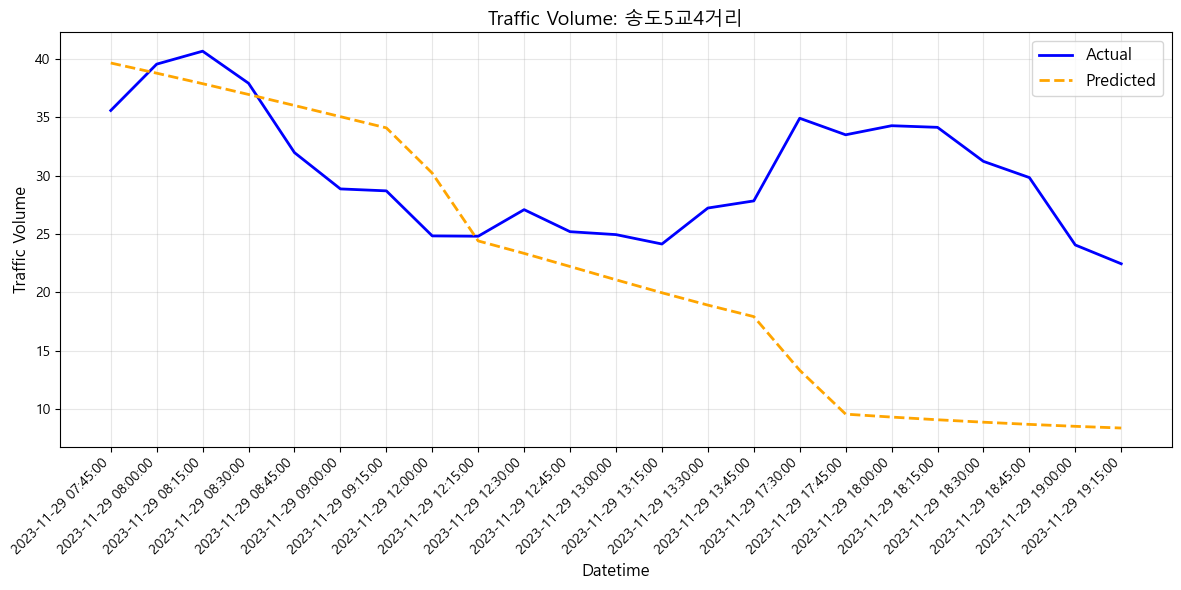

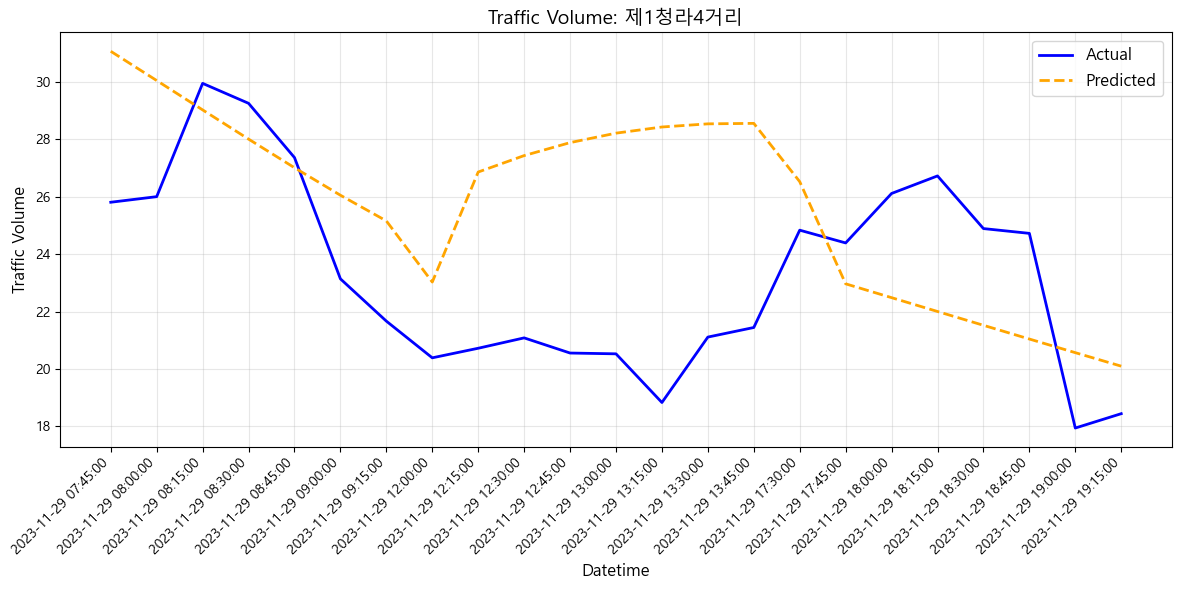

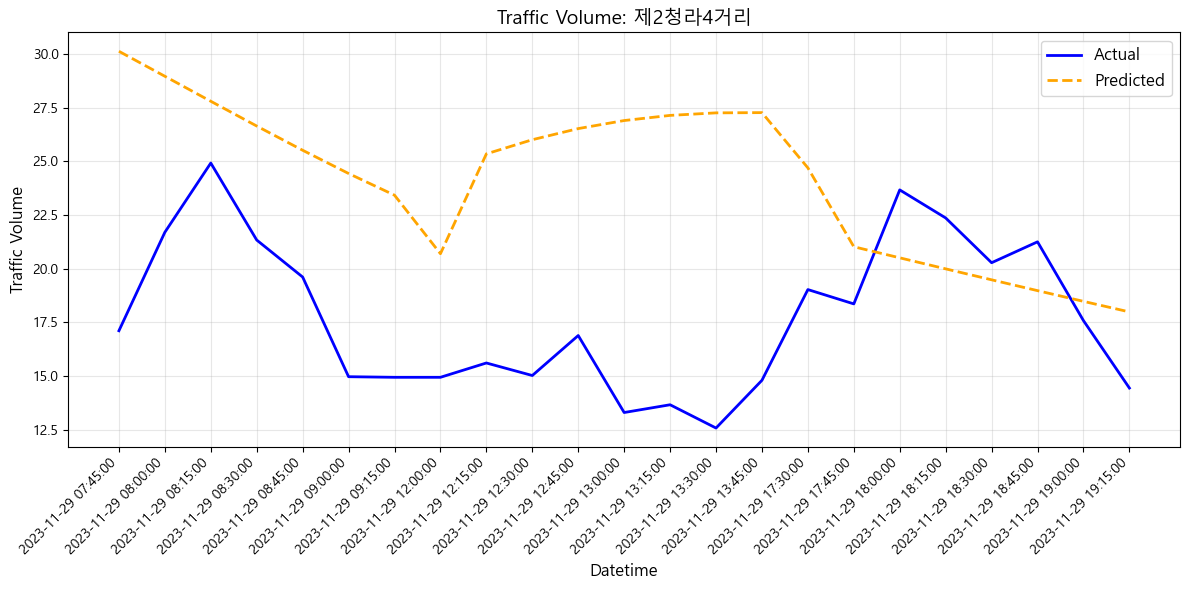

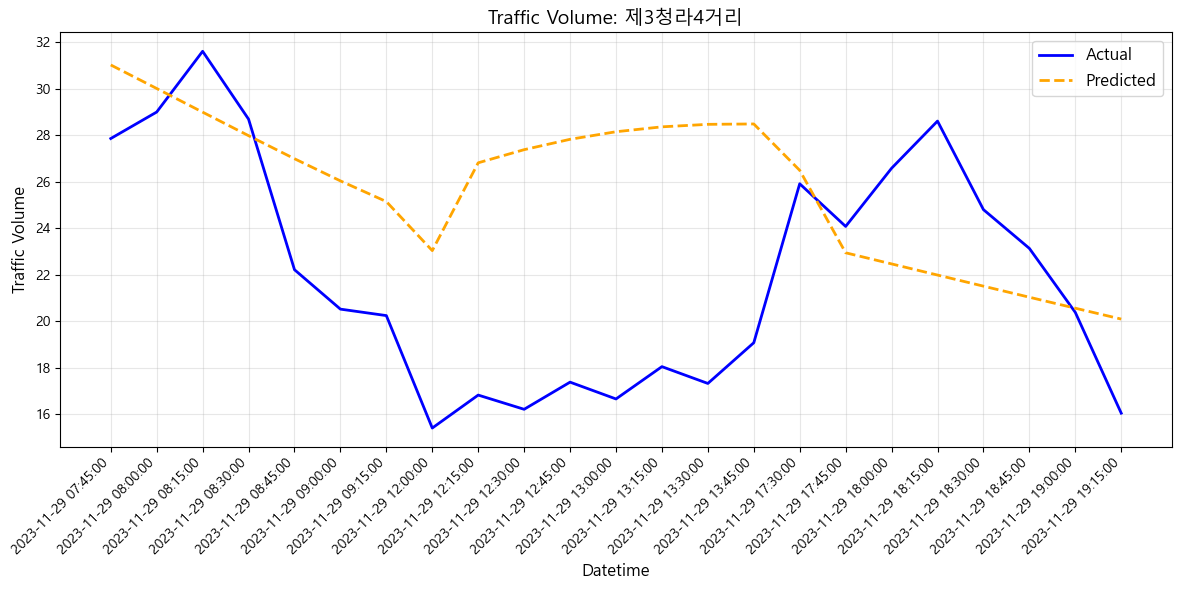

In [37]:
# 교차로별 시각화
for result in results:
    intersection = result['intersection']
    predicted = result['predicted']
    actual = result['actual']

     # 교차로별 datetime 데이터 슬라이싱
    intersection_data = mapping_info[mapping_info['교차로명'] == intersection]
    datetime_labels = intersection_data['datetime'].iloc[-rows_per_intersection:]  # 뒤에서부터 rows_per_intersection 개수 가져오기


    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(actual)), actual, label='Actual', color='blue', linewidth=2)
    plt.plot(range(len(predicted)), predicted, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.title(f"Traffic Volume: {intersection}", fontsize=14)
    plt.xlabel("Datetime", fontsize=12)
    plt.ylabel("Traffic Volume", fontsize=12)
    plt.xticks(range(len(datetime_labels)), datetime_labels, rotation=45, ha='right')  # x축에 datetime 레이블 추가
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [28]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

# RMSE 함수
def RMSE(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

# MAPE 함수
def MAPE(true, pred):
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

In [38]:
print("MAE:", MAE((np.array(y_test_original)), (np.array(y_pred_original))))
print("RMSE:", RMSE((np.array(y_test_original)), (np.array(y_pred_original))))
print("MAPE:", MAPE((np.array(y_test_original)), (np.array(y_pred_original))))

MAE: 8.043985178455479
RMSE: 10.588753927548819
MAPE: 38.303212851108555
